### Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

%matplotlib inline

### Functions

In [2]:
def scale_series(df,mode="close"):
    if mode=="close":
        series = df['close'].values.reshape(-1,1)
    elif mode=="return":
        series = df['return'].values[1:].reshape(-1,1)
    scaler = StandardScaler()
    scaler.fit(series[:len(series)//2])
    series = scaler.transform(series).flatten()
    return scaler, series
    

def plot_series(series):
    plt.plot(series)
    plt.show()

def create_dataset(series,T):
    X = []
    Y = []
    for t in range(len(series)-T):
        x = series[t:t+T]
        X.append(x)
        y = series[t+T]
        Y.append(y)
        
    X = np.array(X).reshape(-1,T,1)
    Y = np.array(Y).reshape(-1,1)
        
    N = len(X)
    print(N)
    print("X.shape",X.shape,"Y.shape",Y.shape)
    return X,Y,N   


class SimpleRNN(nn.Module):
    def __init__(self,n_inputs, n_hidden, n_rnnlayers, n_outputs, model_type, device):
        super(SimpleRNN,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        self.model_type = model_type
        self.device = device
        
        if self.model_type=="GRU":
            self.rnn = nn.GRU(
                input_size = self.D,
                hidden_size = self.M,
                num_layers = self.L,
                batch_first=True
            )
        elif self.model_type=="LSTM":
            self.rnn = nn.LSTM(
                input_size = self.D,
                hidden_size = self.M,
                num_layers = self.L,
                batch_first=True
            )
            
        self.fc = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(self.device)
        if self.model_type=="LSTM":
            c0 = torch.zeros(self.L, X.size(0), self.M).to(self.device)
            out,_ = self.rnn(X, (h0,c0))
        elif self.model_type=="GRU":
            out,_ = self.rnn(X, h0)
        
        out = self.fc(out[:, -1, :])
        return out


def create_model_and_train(X,Y,T,N,D,M,L,K,n_epochs=100,model_type="Linear"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    if model_type=="Linear":
        model = nn.Linear(T,1)
    elif model_type=="GRU":
        model = SimpleRNN(n_inputs=D, n_hidden=M, n_rnnlayers=L, n_outputs=K, model_type=model_type, device=device)
    elif model_type=="LSTM":
        model = SimpleRNN(n_inputs=D, n_hidden=M, n_rnnlayers=L, n_outputs=K, model_type=model_type, device=device)


    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.05)
    
    # random split is not reasonable in time series
    
    X_train = torch.from_numpy(X[:-N//2].astype(np.float32)).to(device)
    y_train = torch.from_numpy(Y[:-N//2].astype(np.float32)).to(device)
    X_test = torch.from_numpy(X[-N//2:].astype(np.float32)).to(device)
    y_test = torch.from_numpy(Y[-N//2:].astype(np.float32)).to(device)
    
    train_losses = np.zeros(n_epochs)
    test_losses  = np.zeros(n_epochs)
    
    for it in range(n_epochs):
        optimizer.zero_grad()
        
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        loss.backward()
        optimizer.step()
        
        train_losses[it] = loss.item()
        
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
        
        
        if (it+1)%5==0:

            print(f"Epoch {it+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")
        
    return model,train_losses, test_losses, device,X_test,y_test


def plot_metric(data, metric):
    plt.plot(data, label=metric)
    plt.legend()
    plt.show
    
    
def wrong_forcasting(Y,N,X_test,model,model_type="Linear",T=None):
    validation_target = Y[-N//2:]
    validation_predictions = []
    
    i=0
    while len(validation_predictions)<len(validation_target):
        if model_type=="Linear":
            input_ = X_test[i].reshape(1,-1)
        elif model_type in ["GRU","LSTM"]:
            input_ = X_test[i].reshape(1,T,-1)
            
        p = model(input_)[0,0].item()
        i+=1
        validation_predictions.append(p)
        
    return validation_predictions,validation_target

def correct_forcasting(Y,N,X_test,model,model_type="Linear",T=None):
    validation_target = Y[-N//2:]
    validation_predictions = []
    
    if model_type=="Linear":
        last_x = torch.from_numpy(X[-N//2].astype(np.float32))
    elif model_type in ["GRU","LSTM"]:
        last_x = X_test[0].view(T)
            
    while len(validation_predictions)<len(validation_target):
        if model_type=="Linear":
            input_ = last_x.view(1,-1)
        elif model_type in ["GRU","LSTM"]:
            input_ = last_x.view(1,T,-1)
            
        p = model(input_)
        
        validation_predictions.append(p[0,0].item())
        
        last_x = torch.cat((last_x[1:],p[0]))
        
    return validation_predictions,validation_target


def return_calculator(df,t):
    df["prev_close"] = df["close"].shift(t)
    df["return"] = df["close"]/df["prev_close"]-1
#     df["return2"] = df["close"].pct_change(t)
    df["log_return"] = np.log(df["return"]+1)
    return df

### Part1: Price Prediction

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [4]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [5]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


### Wrong forecasintg

In [6]:
scaler,series = scale_series(df)

In [7]:
T=20
D=1
M=5
L=1
K=1
X,Y,N = create_dataset(series,T)

model_type = "LSTM"

1239
X.shape (1239, 20, 1) Y.shape (1239, 1)


In [8]:
model,train_losses, test_losses, device, X_test, y_test = create_model_and_train(X,Y,T=T,N=N,D=D,M=M,L=L,K=K,n_epochs=200,model_type=model_type)

cpu
Epoch 5/200, Train Loss: 0.4104, Test Loss: 1.8616
Epoch 10/200, Train Loss: 0.1803, Test Loss: 0.2119
Epoch 15/200, Train Loss: 0.0429, Test Loss: 0.2528
Epoch 20/200, Train Loss: 0.0263, Test Loss: 0.1809
Epoch 25/200, Train Loss: 0.0242, Test Loss: 0.1376
Epoch 30/200, Train Loss: 0.0077, Test Loss: 0.1319
Epoch 35/200, Train Loss: 0.0107, Test Loss: 0.1084
Epoch 40/200, Train Loss: 0.0085, Test Loss: 0.0842
Epoch 45/200, Train Loss: 0.0062, Test Loss: 0.0805
Epoch 50/200, Train Loss: 0.0072, Test Loss: 0.0811
Epoch 55/200, Train Loss: 0.0063, Test Loss: 0.0672
Epoch 60/200, Train Loss: 0.0059, Test Loss: 0.0652
Epoch 65/200, Train Loss: 0.0061, Test Loss: 0.0634
Epoch 70/200, Train Loss: 0.0059, Test Loss: 0.0568
Epoch 75/200, Train Loss: 0.0058, Test Loss: 0.0571
Epoch 80/200, Train Loss: 0.0058, Test Loss: 0.0541
Epoch 85/200, Train Loss: 0.0057, Test Loss: 0.0504
Epoch 90/200, Train Loss: 0.0057, Test Loss: 0.0499
Epoch 95/200, Train Loss: 0.0057, Test Loss: 0.0474
Epoch 100

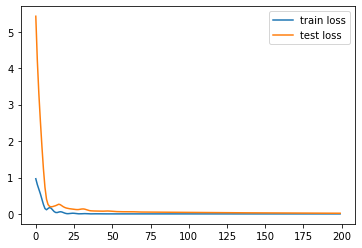

In [9]:
plot_metric(train_losses, "train loss")
plot_metric(test_losses, "test loss")

### Wrong Forecasting

In [10]:
validation_predictions,validation_target = wrong_forcasting(Y,N,X_test,model,model_type=model_type,T=T)

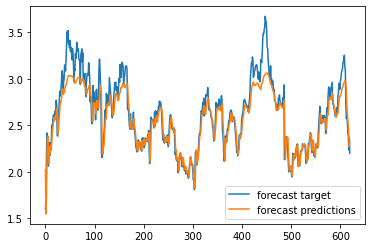

In [11]:
plot_metric(validation_target, "forecast target")
plot_metric(validation_predictions, "forecast predictions")

### Correct forecasting

In [12]:
validation_predictions,validation_target = correct_forcasting(Y,N,X_test,model,model_type=model_type,T=T)

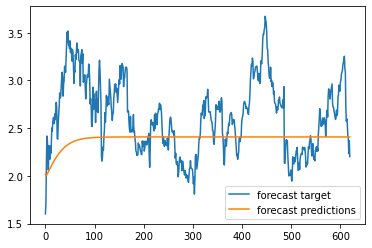

In [13]:
plot_metric(validation_target, "forecast target")
plot_metric(validation_predictions, "forecast predictions")

### Part 2: Returns

In [14]:
df = return_calculator(df,t=1)

In [15]:
df.head()

,date,open,high,low,close,volume,Name,prev_close,return,log_return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080,-0.004089
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138,0.002135
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643,-0.007672
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015,-0.005028


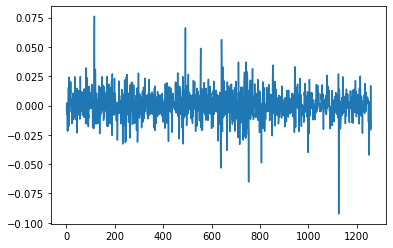

In [16]:
plt.plot(df['return'])

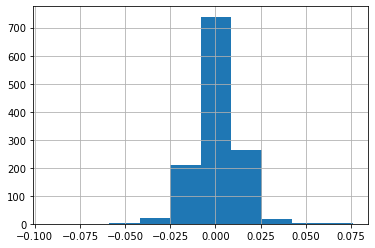

In [17]:
df['return'].hist();

In [18]:
scaler_return, series_return= scale_series(df,mode="return")

In [19]:
X_return,Y_return,N_return = create_dataset(series_return,T)

1238
X.shape (1238, 20, 1) Y.shape (1238, 1)


In [27]:
model_return,train_losses_return, test_losses_return, device, X_test_return, y_test_return = create_model_and_train(X_return,Y_return,T=T,N=N,D=D,M=M,L=L,K=K,n_epochs=200,model_type=model_type)

cpu
Epoch 5/200, Train Loss: 1.0366, Test Loss: 1.1160
Epoch 10/200, Train Loss: 1.0248, Test Loss: 1.0951
Epoch 15/200, Train Loss: 1.0209, Test Loss: 1.1034
Epoch 20/200, Train Loss: 1.0145, Test Loss: 1.1139
Epoch 25/200, Train Loss: 1.0085, Test Loss: 1.1241
Epoch 30/200, Train Loss: 1.0048, Test Loss: 1.1248
Epoch 35/200, Train Loss: 1.0019, Test Loss: 1.1467
Epoch 40/200, Train Loss: 0.9977, Test Loss: 1.1486
Epoch 45/200, Train Loss: 0.9915, Test Loss: 1.1515
Epoch 50/200, Train Loss: 0.9816, Test Loss: 1.1649
Epoch 55/200, Train Loss: 0.9656, Test Loss: 1.2056
Epoch 60/200, Train Loss: 0.9465, Test Loss: 1.2941
Epoch 65/200, Train Loss: 0.9314, Test Loss: 1.3106
Epoch 70/200, Train Loss: 0.9127, Test Loss: 1.3738
Epoch 75/200, Train Loss: 0.9162, Test Loss: 1.4646
Epoch 80/200, Train Loss: 0.8933, Test Loss: 1.4021
Epoch 85/200, Train Loss: 0.8763, Test Loss: 1.4635
Epoch 90/200, Train Loss: 0.8859, Test Loss: 1.4478
Epoch 95/200, Train Loss: 0.8699, Test Loss: 1.4879
Epoch 100

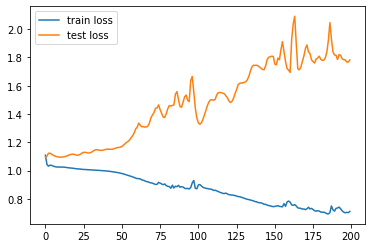

In [28]:
plot_metric(train_losses_return, "train loss")
plot_metric(test_losses_return, "test loss")

### Wrong Forecasting

In [29]:
validation_predictions_return,validation_target_return = wrong_forcasting(Y_return,N,X_test_return,model_return,model_type=model_type,T=T)

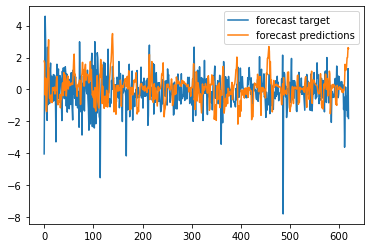

In [30]:
plot_metric(validation_target_return, "forecast target")
plot_metric(validation_predictions_return, "forecast predictions")

### Correct forecasting

In [31]:
validation_predictions_return,validation_target_return = correct_forcasting(Y_return,N,X_test_return,model_return,model_type=model_type,T=T)

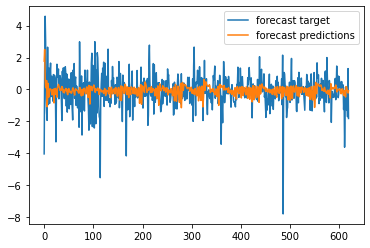

In [32]:
plot_metric(validation_target_return, "forecast target")
plot_metric(validation_predictions_return, "forecast predictions")